In [3]:
!git clone https://github.com/luca-medeiros/lang-segment-anything

Cloning into 'lang-segment-anything'...


In [1]:
%cd lang-segment-anything

C:\Users\supha\Documents\65011048\lang-segment-anything


C:\Users\supha\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pip install torch torchvision

You should consider upgrading via the 'C:\Users\supha\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install .


Processing c:\users\supha\documents\65011048\lang-segment-anything
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\supha\appdata\local\temp\pip-install-5idokbek\segment-anything_07b90d1b26b747fe9178e85c02f3c9f9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to c:\users\supha\appdata\local\temp\pip-install-5idokbek\groundingdino_c34ee2be958d4dcab3de05a998992ea1
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 856dde20aee659246248e20734ef9ba5214f5e44
  Created wheel for lang-sam: filename=lang_sam-

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Running command git clone -q https://github.com/facebookresearch/segment-anything.git 'C:\Users\supha\AppData\Local\Temp\pip-install-5idokbek\segment-anything_07b90d1b26b747fe9178e85c02f3c9f9'
  Running command git clone -q https://github.com/IDEA-Research/GroundingDINO.git 'C:\Users\supha\AppData\Local\Temp\pip-install-5idokbek\groundingdino_c34ee2be958d4dcab3de05a998992ea1'
You should consider upgrading via the 'C:\Users\supha\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [16]:
import os
from PIL import Image
from lang_sam import LangSAM
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [2]:
# สร้างโมเดล LangSAM
model = LangSAM()

final text_encoder_type: bert-base-uncased


Model loaded from C:\Users\supha\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [17]:
folder_path = r"C:\Users\supha\Documents\65011048\result"

In [18]:
# กำหนด prompt สำหรับการประมวลผล
text_prompt = "hand, cup, straw"                                 

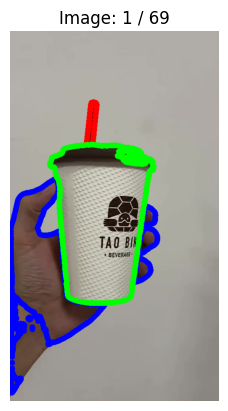

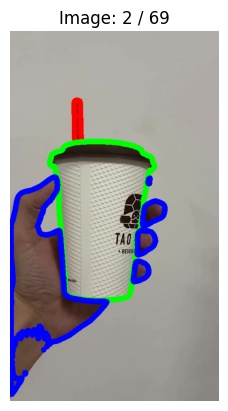

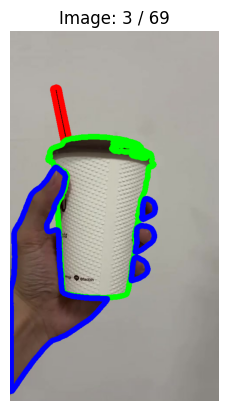

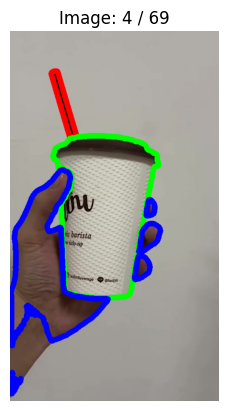

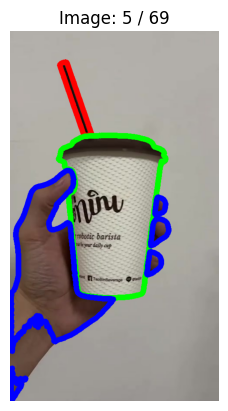

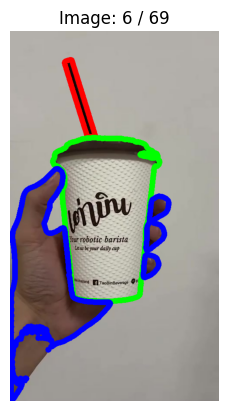

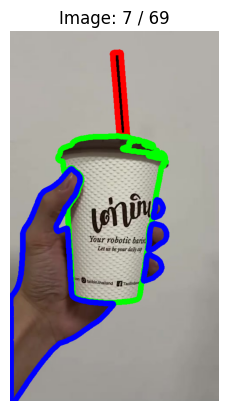

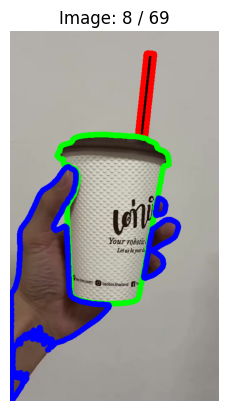

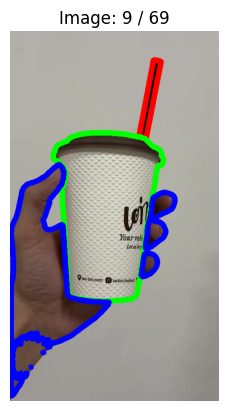

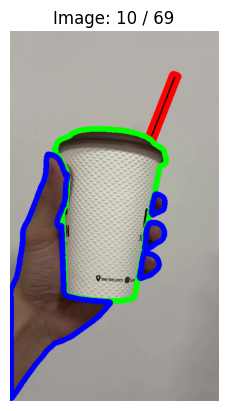

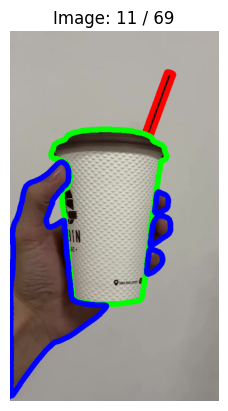

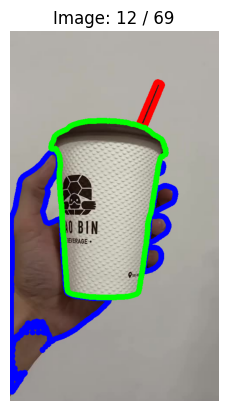

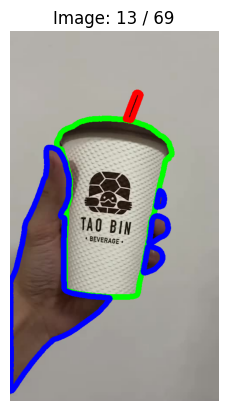

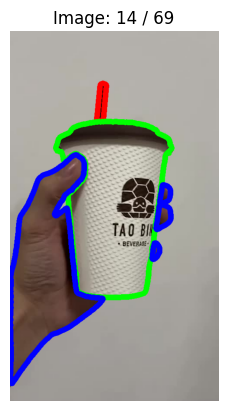

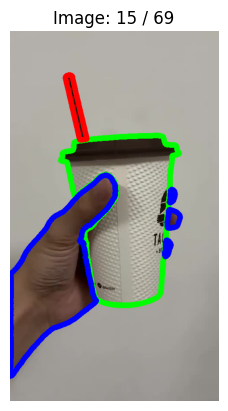

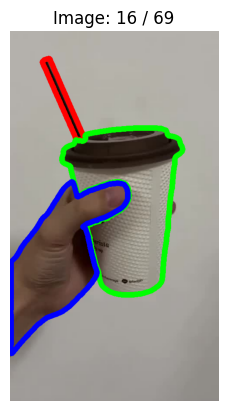

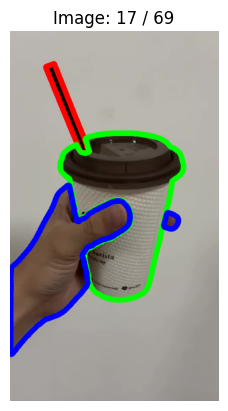

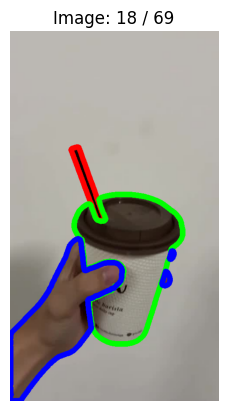

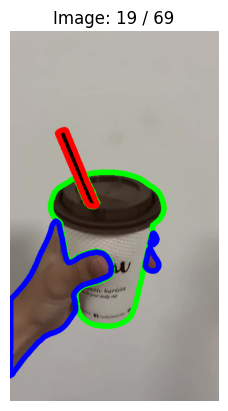

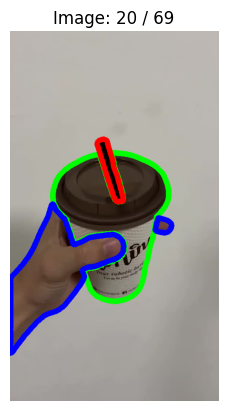

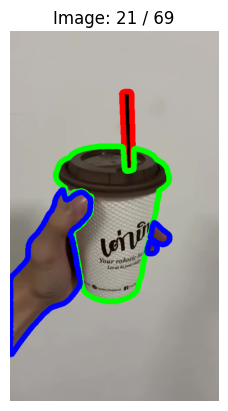

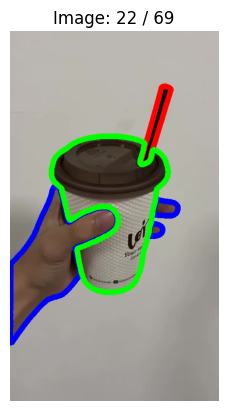

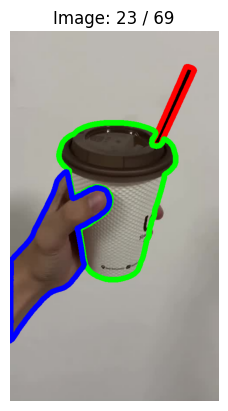

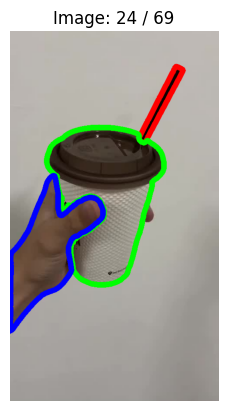

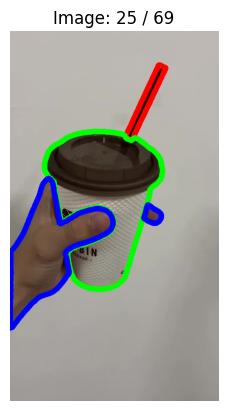

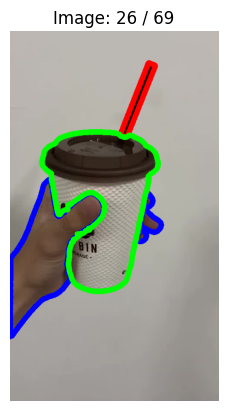

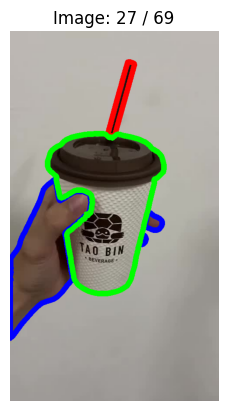

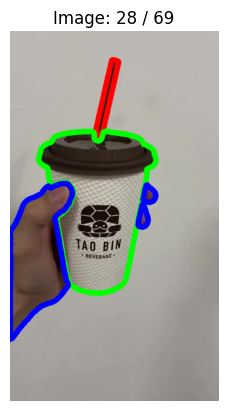

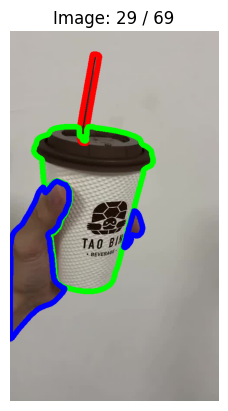

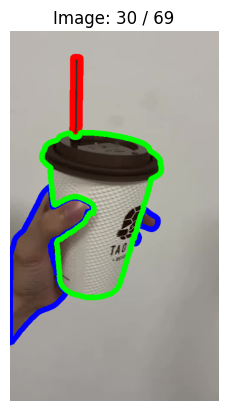

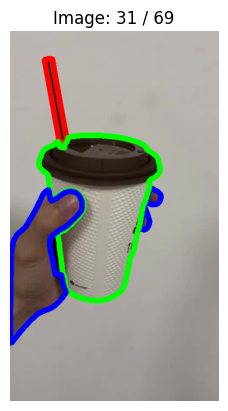

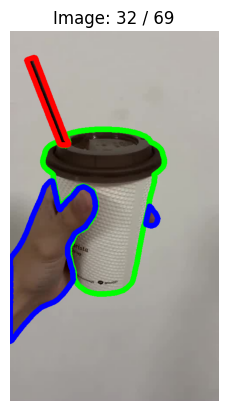

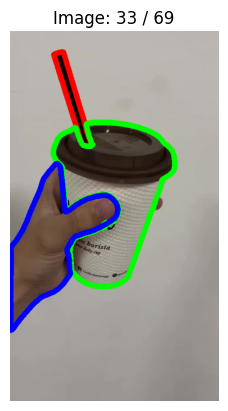

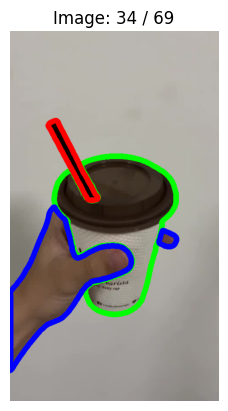

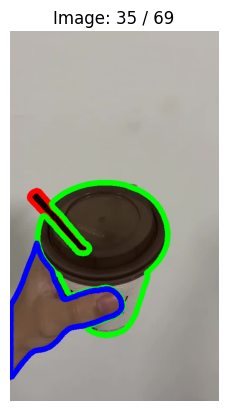

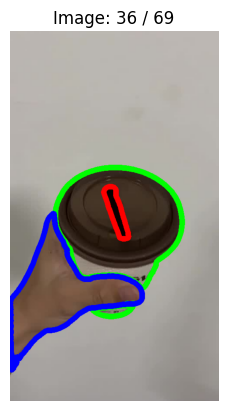

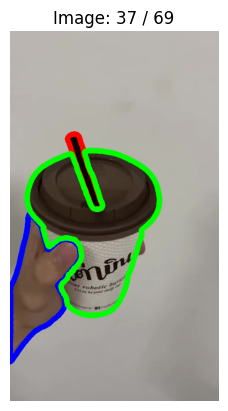

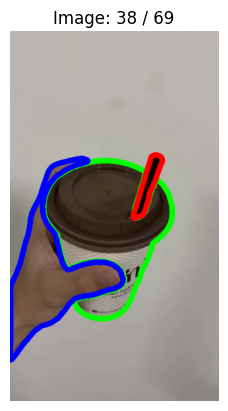

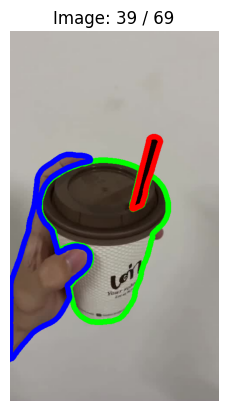

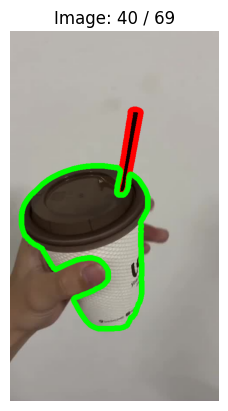

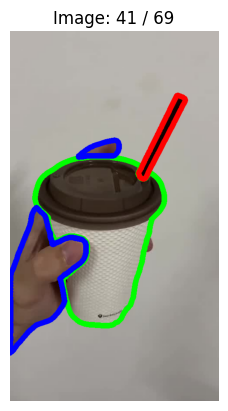

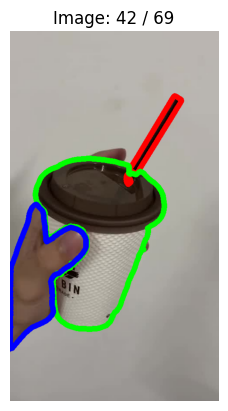

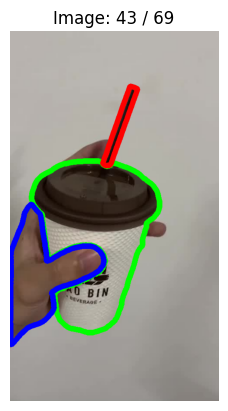

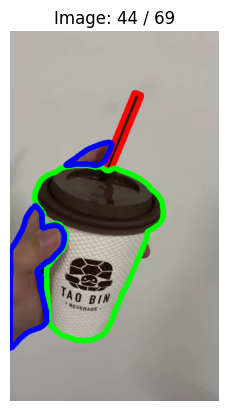

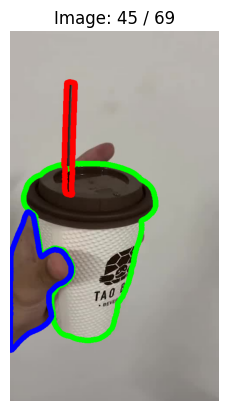

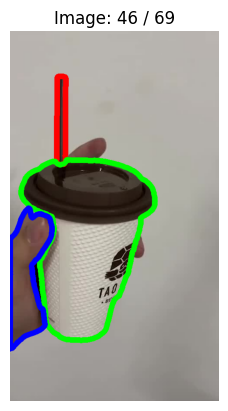

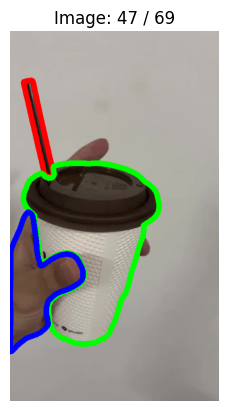

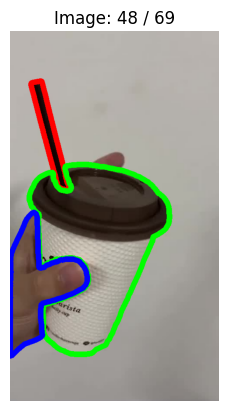

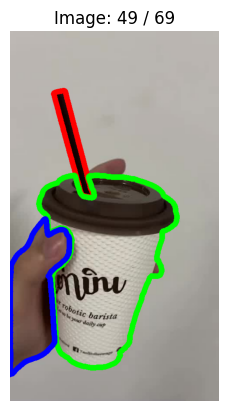

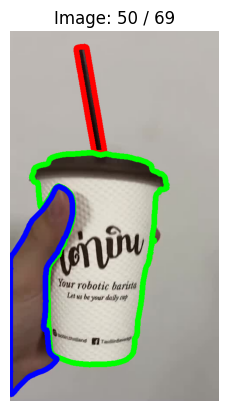

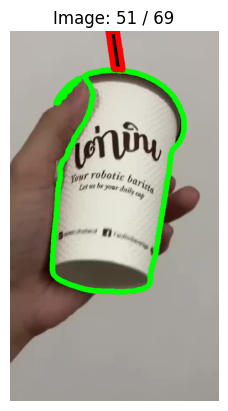

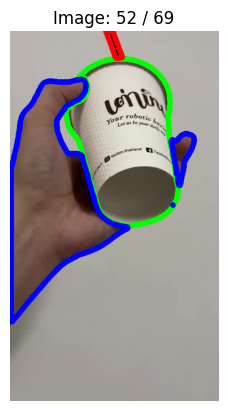

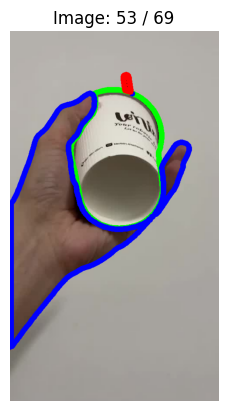

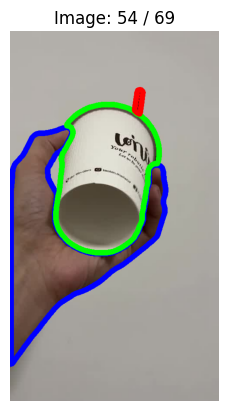

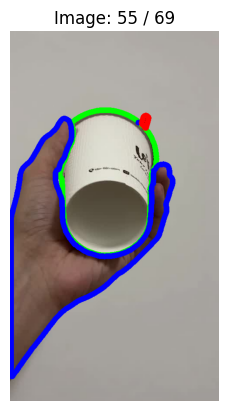

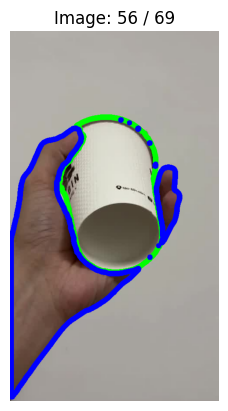

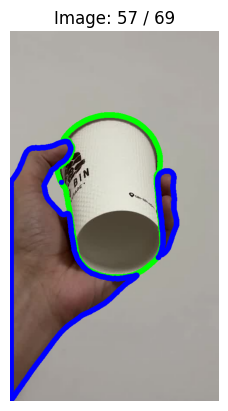

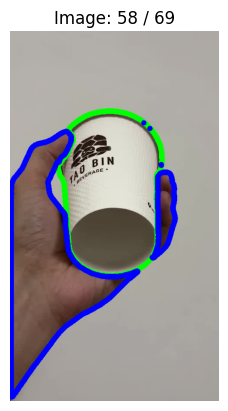

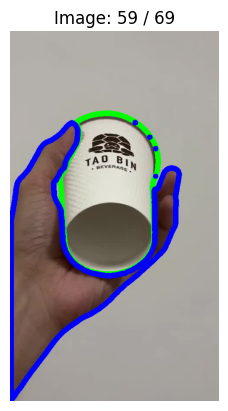

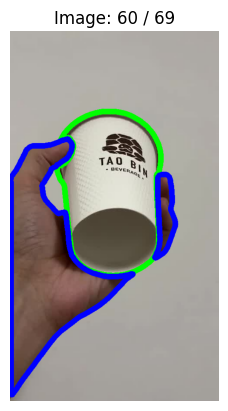

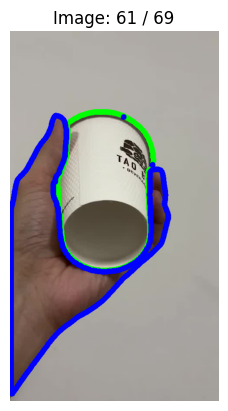

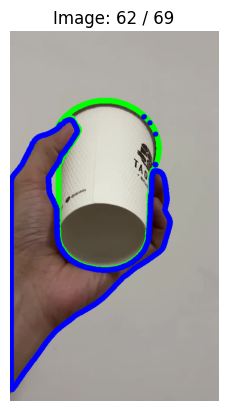

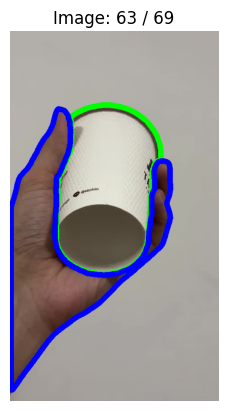

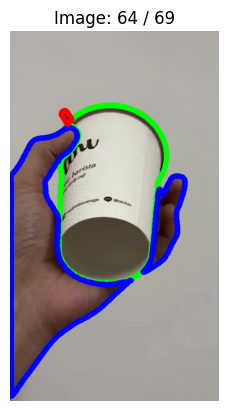

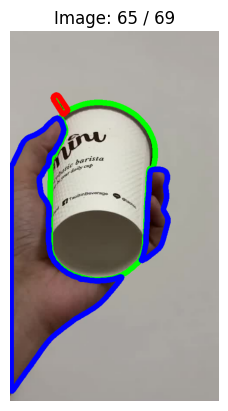

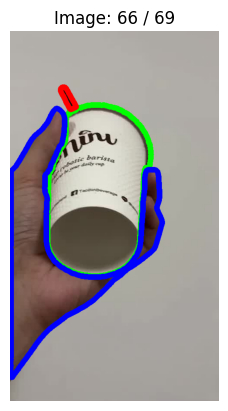

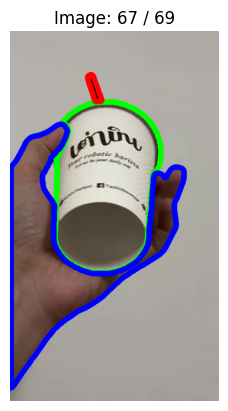

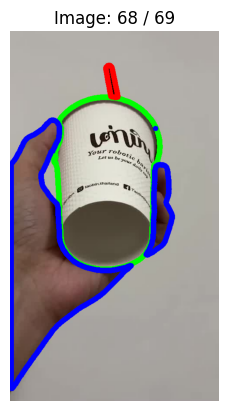

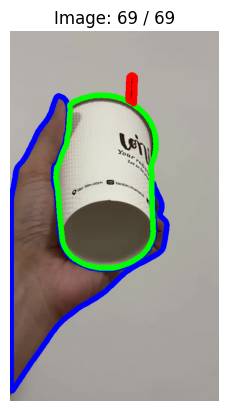

In [19]:
# วนลูปผ่านไฟล์ทั้งหมดในโฟลเดอร์
for index_filename, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # ตรวจสอบเฉพาะไฟล์ภาพ
        # สร้าง path สำหรับไฟล์ภาพแต่ละไฟล์
        image_path = os.path.join(folder_path, filename)

        # ลดขนาดภาพให้มีความกว้างและสูงที่เล็กลง
        resize_width = 225
        resize_height = 400
        
        # เปิดภาพด้วย PIL
        # image_pil = Image.open(image_path).convert("RGB").resize((resize_width, resize_height))
        image_pil = Image.open(image_path).convert("RGB")

        # ใช้โมเดล LangSAM เพื่อทำการพยากรณ์
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        
        def calculate_iou(box1, box2):
            x1_max = max(box1[0], box2[0])
            y1_max = max(box1[1], box2[1])
            x2_min = min(box1[2], box2[2])
            y2_min = min(box1[3], box2[3])
    
    
            inter_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)
            
            
            box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
            box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
            
            
            iou = inter_area / float(box1_area + box2_area - inter_area)
            return iou


        iou_threshold = 0.5  
        selected_boxes = []
        selected_masks = []
        selected_logits = []
        selected_phrases = []


        for i, box in enumerate(boxes):
            keep = True
            for j in range(len(selected_boxes)):
                iou = calculate_iou(box, selected_boxes[j])
                if iou > iou_threshold:
                    if logits[i] > selected_logits[j]:  
                        selected_boxes[j] = box
                        selected_masks[j] = masks[i]
                        selected_logits[j] = logits[i]
                        selected_phrases[j] = phrases[i]
                    keep = False
                    break
            if keep:
                selected_boxes.append(box)
                selected_masks.append(masks[i])
                selected_logits.append(logits[i])
                selected_phrases.append(phrases[i])

        masks_np = np.array([mask.detach().cpu().numpy() for mask in selected_masks])
 


        # แปลงภาพ PIL เป็น NumPy array
        image_np = np.array(image_pil).copy()
        
        # สร้างภาพที่มี mask ทั้งหมด
        image_with_all_masks = image_np.copy()
        
        
        # วาดขอบ mask ของแต่ละวัตถุลงในภาพ
        for i, mask in enumerate(selected_masks):
            # กำหนดสีที่ต่างกันสำหรับแต่ละวัตถุ
            if selected_phrases[i] == 'hand':
                mask_color = [0, 0, 255]  # สีน้ำเงิน
            elif selected_phrases[i] == 'cup':
                mask_color = [0, 255, 0]  # สีเขียว
            elif selected_phrases[i] == 'straw':
                mask_color = [255, 0, 0]  # สีแดง
            else:
                mask_color = [0, 255, 255]  # สีม่วง
        
            # แปลง mask ให้เป็นรูปแบบที่ OpenCV รองรับ (uint8)
            mask_uint8 = (masks_np[i] * 255).astype(np.uint8)
        
            # หาขอบของ mask ด้วย OpenCV
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # วาดขอบของ mask บนภาพต้นฉบับ
            cv2.drawContours(image_with_all_masks, contours, -1, mask_color, thickness=12)  # กำหนดความหนาของขอบได้ด้วย 'thickness'
        
        # แสดงภาพพร้อมขอบ mask ทั้งหมด
        plt.imshow(image_with_all_masks)
        plt.axis('off')
        plt.title(f"Image: {index_filename + 1} / {len(os.listdir(folder_path))}")

        
        # # วาด bounding box ของแต่ละวัตถุด้วยสีที่ตรงกับ mask
        # for i, box in enumerate(selected_boxes):
        #     # แปลงสี mask จาก [0-255] ไปเป็น [0-1] สำหรับการวาด bounding box
        #     box_color = [c / 255 for c in mask_color]
        
        #     x1, y1, x2, y2 = box
        #     plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=box_color, linewidth=3))
        
        # แสดงผลลัพธ์สุดท้าย
        plt.show()

In [23]:
print(selected_boxes)
print(selected_masks)
print(selected_logits)
print(selected_phrases)

[tensor([  1.3406, 143.1085, 362.3020, 836.9520]), tensor([ 99.6006, 143.7023, 337.9459, 549.5860]), tensor([268.1406,  98.8612, 289.6727, 169.0948])]
[tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]]), tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]]), tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
      

In [20]:
# เคลียร์ตัวแปรทั้งหมด ยกเว้น model
print(list(globals().keys()))



['LangSAM', 'model', '_i', '_ii', '_iii', '__builtins__', '_i12', '_i13', '_i14', '_i15', 'name', 'gc', '_i16', 'os', 'Image', 'plt', 'np', 'cv2', '_i17', 'folder_path', '_i18', 'text_prompt', '_i19', 'index_filename', 'filename', 'image_path', 'resize_width', 'resize_height', 'image_pil', 'masks', 'boxes', 'phrases', 'logits', 'calculate_iou', 'iou_threshold', 'selected_boxes', 'selected_masks', 'selected_logits', 'selected_phrases', 'i', 'box', 'keep', 'j', 'iou', 'masks_np', 'image_np', 'image_with_all_masks', 'mask', 'mask_color', 'mask_uint8', 'contours', '_', '_i20']


In [13]:
# กำหนดรายชื่อตัวแปรที่ต้องการเก็บไว้
keep_vars = [
    'model', 'LangSAM', 'os', 'Image', 'plt', 'np', 'cv2',  # ตัวแปรที่ผู้ใช้ต้องการเก็บไว้
    'In', 'Out', '_ih', '_oh', '_dh', 'get_ipython', 'exit', 'quit', '__', '___', '_i', '_ii', '_iii'  # ตัวแปรระบบของ Jupyter
]

# ลบตัวแปรทั้งหมด ยกเว้นตัวแปรที่อยู่ใน keep_vars
for name in list(globals()):
    if name not in keep_vars and not name.startswith('_'):  # เก็บตัวแปรที่จำเป็นและไม่ลบตัวแปรที่ขึ้นต้นด้วย '_'
        del globals()[name]

# เรียก garbage collector เพื่อปล่อยหน่วยความจำที่ไม่ใช้แล้ว
import gc
gc.collect()


KeyError: '_oh'

In [15]:
# กำหนดรายชื่อตัวแปรที่ต้องการเก็บไว้ววววววว
keep_vars = [
    'model', 'LangSAM', 'os', 'Image', 'plt', 'np', 'cv2', 
    'In', 'Out', '_ih', '_oh', '_dh', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii'
]

# ลบตัวแปรทั้งหมด ยกเว้นตัวแปรที่อยู่ใน keep_vars
for name in list(globals()):
    if name not in keep_vars and not name.startswith('_'):  # เก็บตัวแปรที่จำเป็นและไม่ลบตัวแปรที่ขึ้นต้นด้วย '_'
        del globals()[name]

# เรียก garbage collector เพื่อปล่อยหน่วยความจำที่ไม่ใช้แล้ว
import gc
gc.collect()


KeyError: '_oh'

In [ ]:
image_pil = Image.open(r"C:\Users\supha\Documents\65011048\test-image\61c9be00112c9421e4ff0ca0_800x0xcover_TcXIogxn.jpg").convert("RGB")
text_prompt = "hand, cup, straw"

In [99]:
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

In [100]:
print(masks, boxes, phrases, logits)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

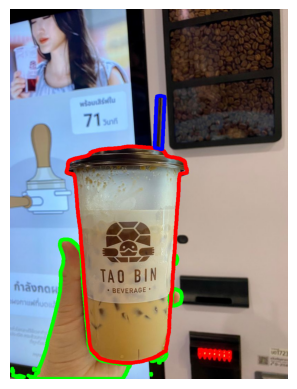

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


def calculate_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])
    
    
    inter_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)
    
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou


iou_threshold = 0.5  
selected_boxes = []
selected_masks = []
selected_logits = []


for i, box in enumerate(boxes):
    keep = True
    for j in range(len(selected_boxes)):
        iou = calculate_iou(box, selected_boxes[j])
        if iou > iou_threshold:
            if logits[i] > selected_logits[j]:  
                selected_boxes[j] = box
                selected_masks[j] = masks[i]
                selected_logits[j] = logits[i]
            keep = False
            break
    if keep:
        selected_boxes.append(box)
        selected_masks.append(masks[i])
        selected_logits.append(logits[i])


masks_np = np.array([mask.detach().cpu().numpy() for mask in selected_masks])
 


# แปลงภาพ PIL เป็น NumPy array
image_np = np.array(image_pil).copy()

# สร้างภาพที่มี mask ทั้งหมด
image_with_all_masks = image_np.copy()


# วาดขอบ mask ของแต่ละวัตถุลงในภาพ
for i, mask in enumerate(selected_masks):
    # กำหนดสีที่ต่างกันสำหรับแต่ละวัตถุ
    if i == 0:
        mask_color = [0, 255, 0]  # สีเขียว
    elif i == 1:
        mask_color = [255, 0, 0]  # สีแดง
    elif i == 2:
        mask_color = [0, 0, 255]  # สีน้ำเงิน
    else:
        mask_color = [0, 255, 255]  # สีเหลือง

    # แปลง mask ให้เป็นรูปแบบที่ OpenCV รองรับ (uint8)
    mask_uint8 = (masks_np[i] * 255).astype(np.uint8)

    # หาขอบของ mask ด้วย OpenCV
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # วาดขอบของ mask บนภาพต้นฉบับ
    cv2.drawContours(image_with_all_masks, contours, -1, mask_color, thickness=10)  # กำหนดความหนาของขอบได้ด้วย 'thickness'

# แสดงภาพพร้อมขอบ mask ทั้งหมด
plt.imshow(image_with_all_masks)
plt.axis('off')

# # วาด bounding box ของแต่ละวัตถุด้วยสีที่ตรงกับ mask
# for i, box in enumerate(selected_boxes):
#     # แปลงสี mask จาก [0-255] ไปเป็น [0-1] สำหรับการวาด bounding box
#     box_color = [c / 255 for c in mask_color]

#     x1, y1, x2, y2 = box
#     plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=box_color, linewidth=3))

# แสดงผลลัพธ์สุดท้าย
plt.show()
